In [27]:
from collections.abc import Generator
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path

import torch
from PIL import Image
from tqdm import tqdm
from transformers import pipeline

assert torch.cuda.is_available(), "CUDA is not available"

In [3]:
DATASET_NAME = '2024-09-15-driver-segmentation-dataset'
DATASET_DIR = Path(f'/home/lanter/source/driver-dataset/{DATASET_NAME}')
MODEL = "depth-anything/Depth-Anything-V2-Small-hf"  # looking good
#MODEL = "depth-anything/Depth-Anything-V2-Base-hf"  # way slower
#MODEL = "Intel/dpt-hybrid-midas"  # trash output

TRAIN_SET_DIR = 'train'
VALID_SET_DIR = 'validation'
TEST_SET_DIR = 'test'

IMAGES_DIR = 'images'

TRAIN_IMAGES = sorted((DATASET_DIR / TRAIN_SET_DIR / IMAGES_DIR).glob('*.jpg'))
VALID_IMAGES = sorted((DATASET_DIR / VALID_SET_DIR / IMAGES_DIR).glob('*.jpg'))
TEST_IMAGES = sorted((DATASET_DIR / TEST_SET_DIR / IMAGES_DIR).glob('*.jpg'))

IMAGE_PATHS = TRAIN_IMAGES + VALID_IMAGES + TEST_IMAGES

## Inference on the whole dataset

In [10]:
# Create depth directories for train, validation and test sets
for path in [TRAIN_IMAGES[0], VALID_IMAGES[0], TEST_IMAGES[0]]:
    (path.parent.parent / 'depth').mkdir(exist_ok=True)

In [11]:
pipe = pipeline(task="depth-estimation", model=MODEL, device=0)

In [25]:
def dataset_batched(batch_size: int = 32) -> Generator[tuple[list[Image.Image], list[Path]]]:
    for i in range(0, len(IMAGE_PATHS), batch_size):
        image_paths_batch = IMAGE_PATHS[i:i+batch_size]
        images = [Image.open(image_path) for image_path in image_paths_batch]
        yield images, image_paths_batch

In [31]:
def save_image(depth_img: Image.Image, export_path: Path) -> None:
    depth_img.save(export_path)

executor = ThreadPoolExecutor(max_workers=4)

In [29]:
# Generating depth images: 450it [16:15,  2.17s/it]  ==> 15 FPS                     
for images, paths in tqdm(
    dataset_batched(batch_size=32),
    total=len(IMAGE_PATHS) // 32,
    desc='Generating depth images',
):
    results = pipe(images)
    depth_images = [res['depth'] for res in results]  # type: ignore

    for depth_img, path in zip(depth_images, paths):
        export_path = path.parent.parent / 'depth' / path.with_suffix('.png').name

        # Submit the image saving to the thread pool. This is non-blocking.
        # The main thread continues to process the next batch of images.
        # Otherwise, GPU would be idle waiting for the images to be saved.
        executor.submit(save_image, depth_img, export_path)  # type: ignore

executor.shutdown(wait=True)

Generating depth images: 450it [16:15,  2.17s/it]                         


## Testing

In [36]:
image_paths = list((DATASET_DIR / 'train' / 'images').glob('*.jpg'))

In [11]:
sample_img_path = (DATASET_DIR / 'train' / 'images').glob('*.jpg').__next__()

In [100]:
pipe = pipeline(task="depth-estimation", model=MODEL, device=0)  # ,torch_dtype=torch.float16

In [ ]:
image = Image.open(sample_img_path)
depth = pipe(image)["depth"]
depth

In [ ]:
for image_path in tqdm(image_paths):
    image = Image.open(image_path)
    depth = pipe(image)["depth"]

In [23]:
def dataset() -> Generator[tuple[Image.Image, Path]]:
    for img_path in IMAGE_PATHS:
        yield Image.open(img_path), img_path

for image, path in tqdm(dataset(), total=len(IMAGE_PATHS), desc='Generating depth images'):
    depth_img: Image.Image = pipe(image)["depth"]  # type: ignore
    export_path = path.parent.parent / 'depth' / path.with_suffix('.png').name
    depth_img.save(export_path)  # type: ignore

## Using Hugging Face Datasets

`pip install datasets[vision]`

[https://huggingface.co/docs/datasets/image_load](https://huggingface.co/docs/datasets/image_load)

In [89]:
def dataset_batched():
    for i in range(0, len(image_paths), 4):
        image_paths_batch = image_paths[i:i+4]
        images = [Image.open(image_path).resize((512,512)) for image_path in image_paths_batch]
        yield images

def dataset():
    for img_path in image_paths:
        yield Image.open(image_path).resize((512,512))

In [ ]:
outputs: list[Image.Image] = []
for batch in tqdm(dataset()):
    depth_img = pipe(batch)["depth"]  # type: ignore
    outputs.append(depth_img)  # type: ignore

In [ ]:
outputs: list[Image.Image] = []
for batch in tqdm(dataset_batched()):
    depths = pipe(batch)
    outputs.extend([depth["depth"] for depth in depths])  # type: ignore

## Model comparison

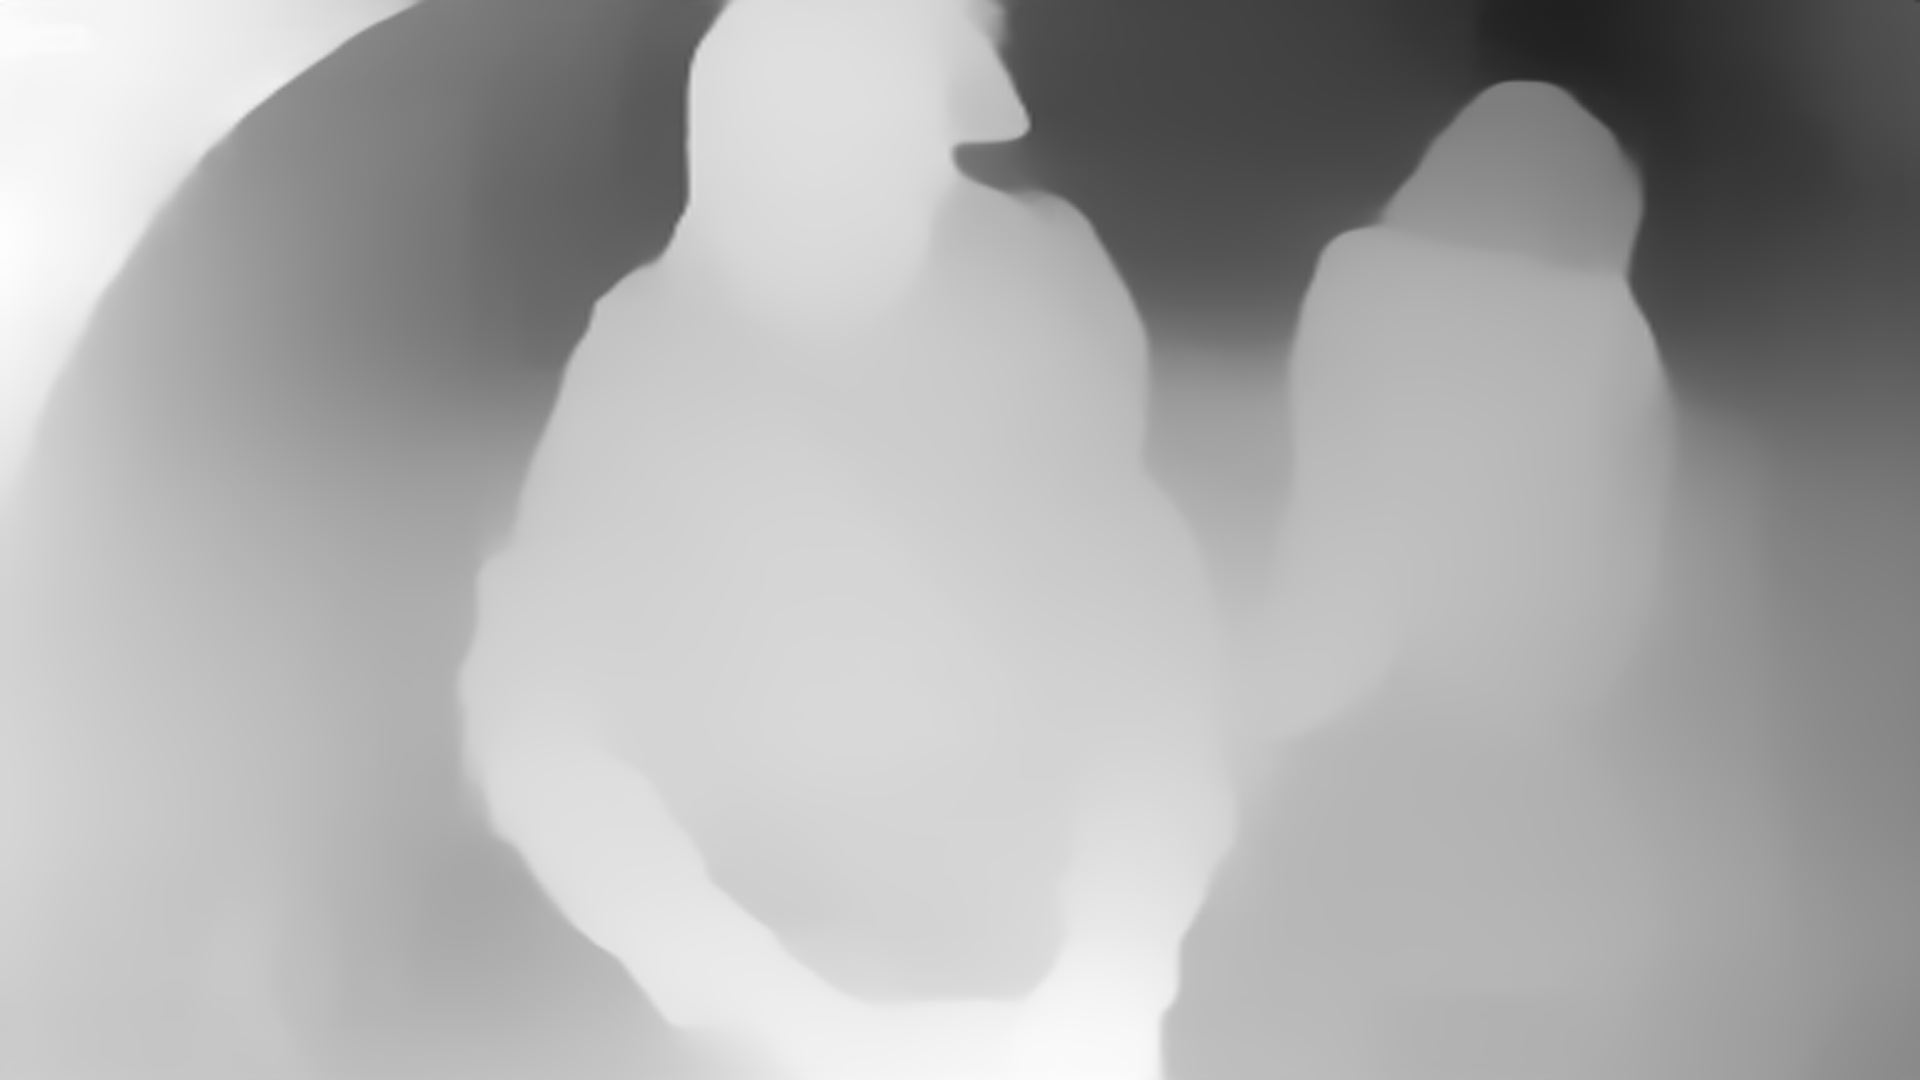

In [33]:
# Intel trash ¯\_(ツ)_/¯ ("Intel/dpt-hybrid-midas")
image = Image.open(sample_img_path)
depth = pipe(image)["depth"]
depth

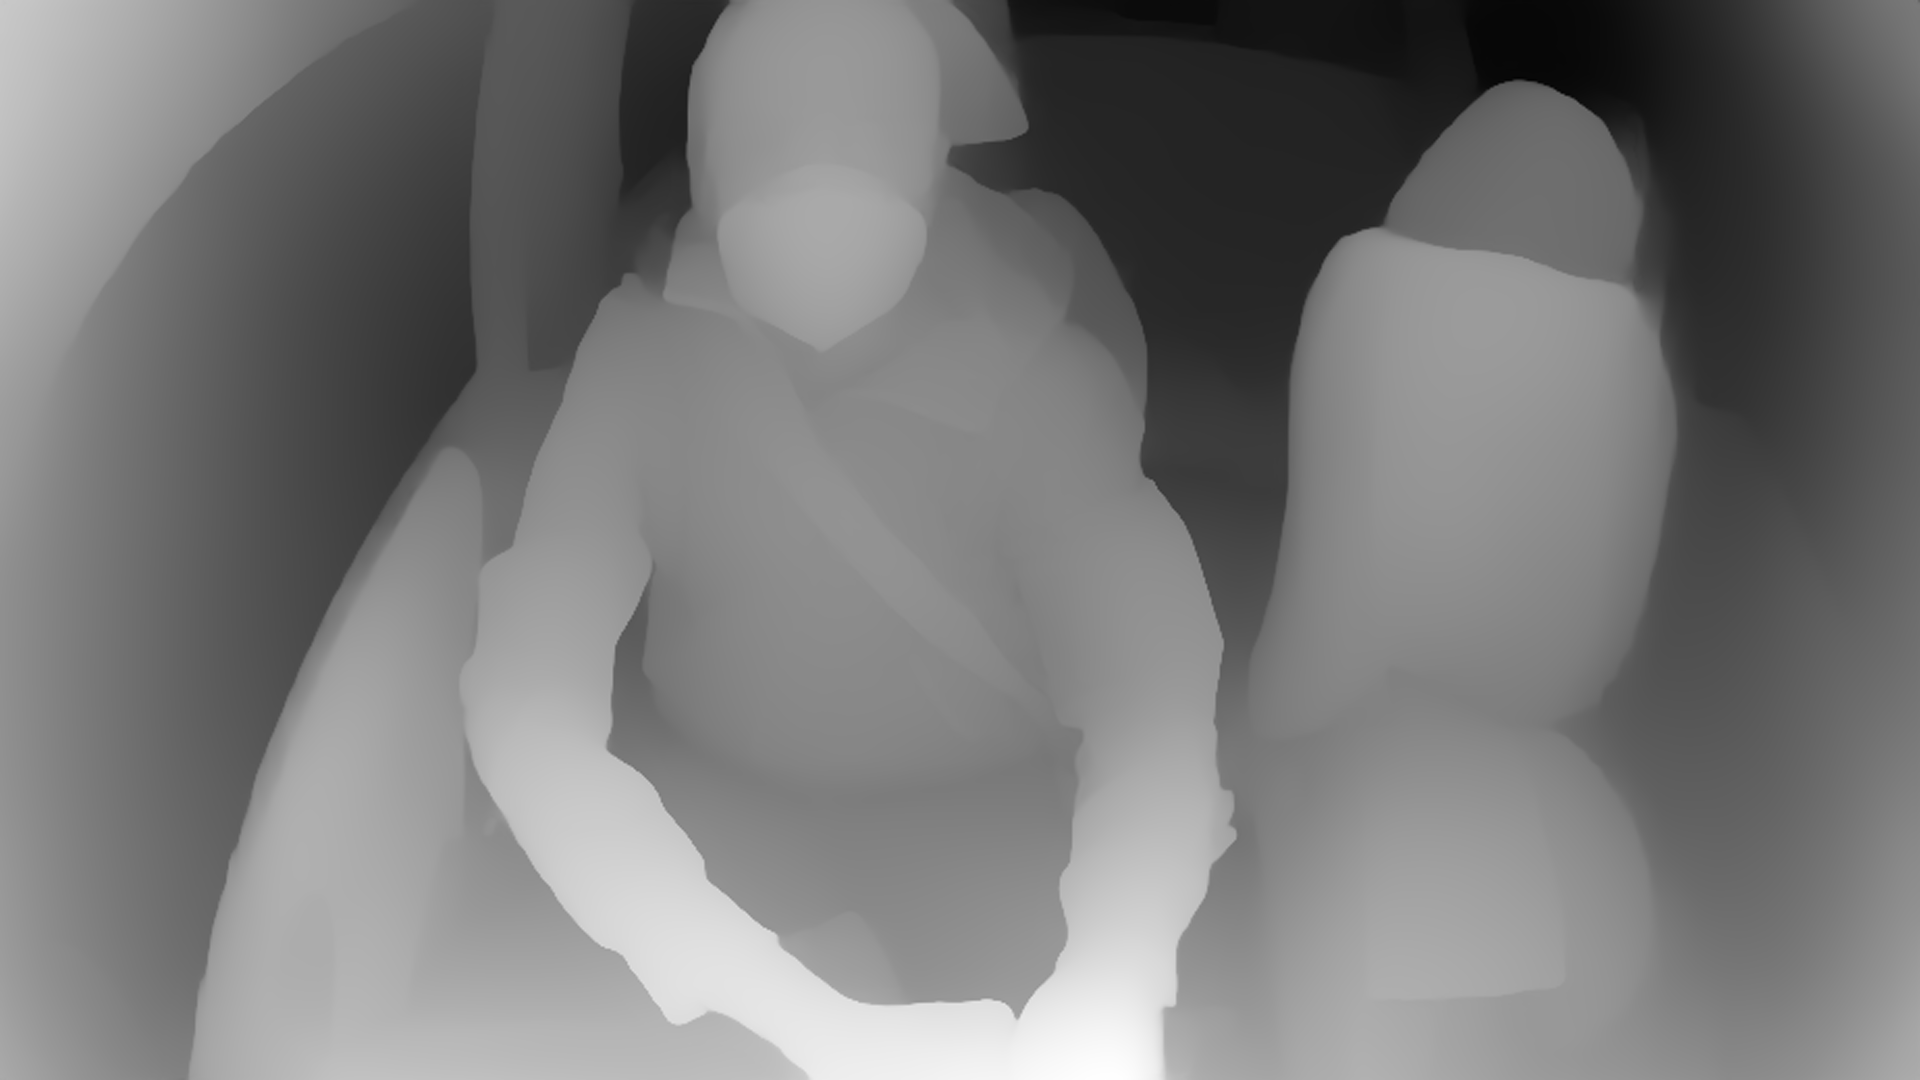

In [30]:
# "depth-anything/Depth-Anything-V2-Small-hf"
image = Image.open(sample_img_path)
depth = pipe(image)["depth"]
depth

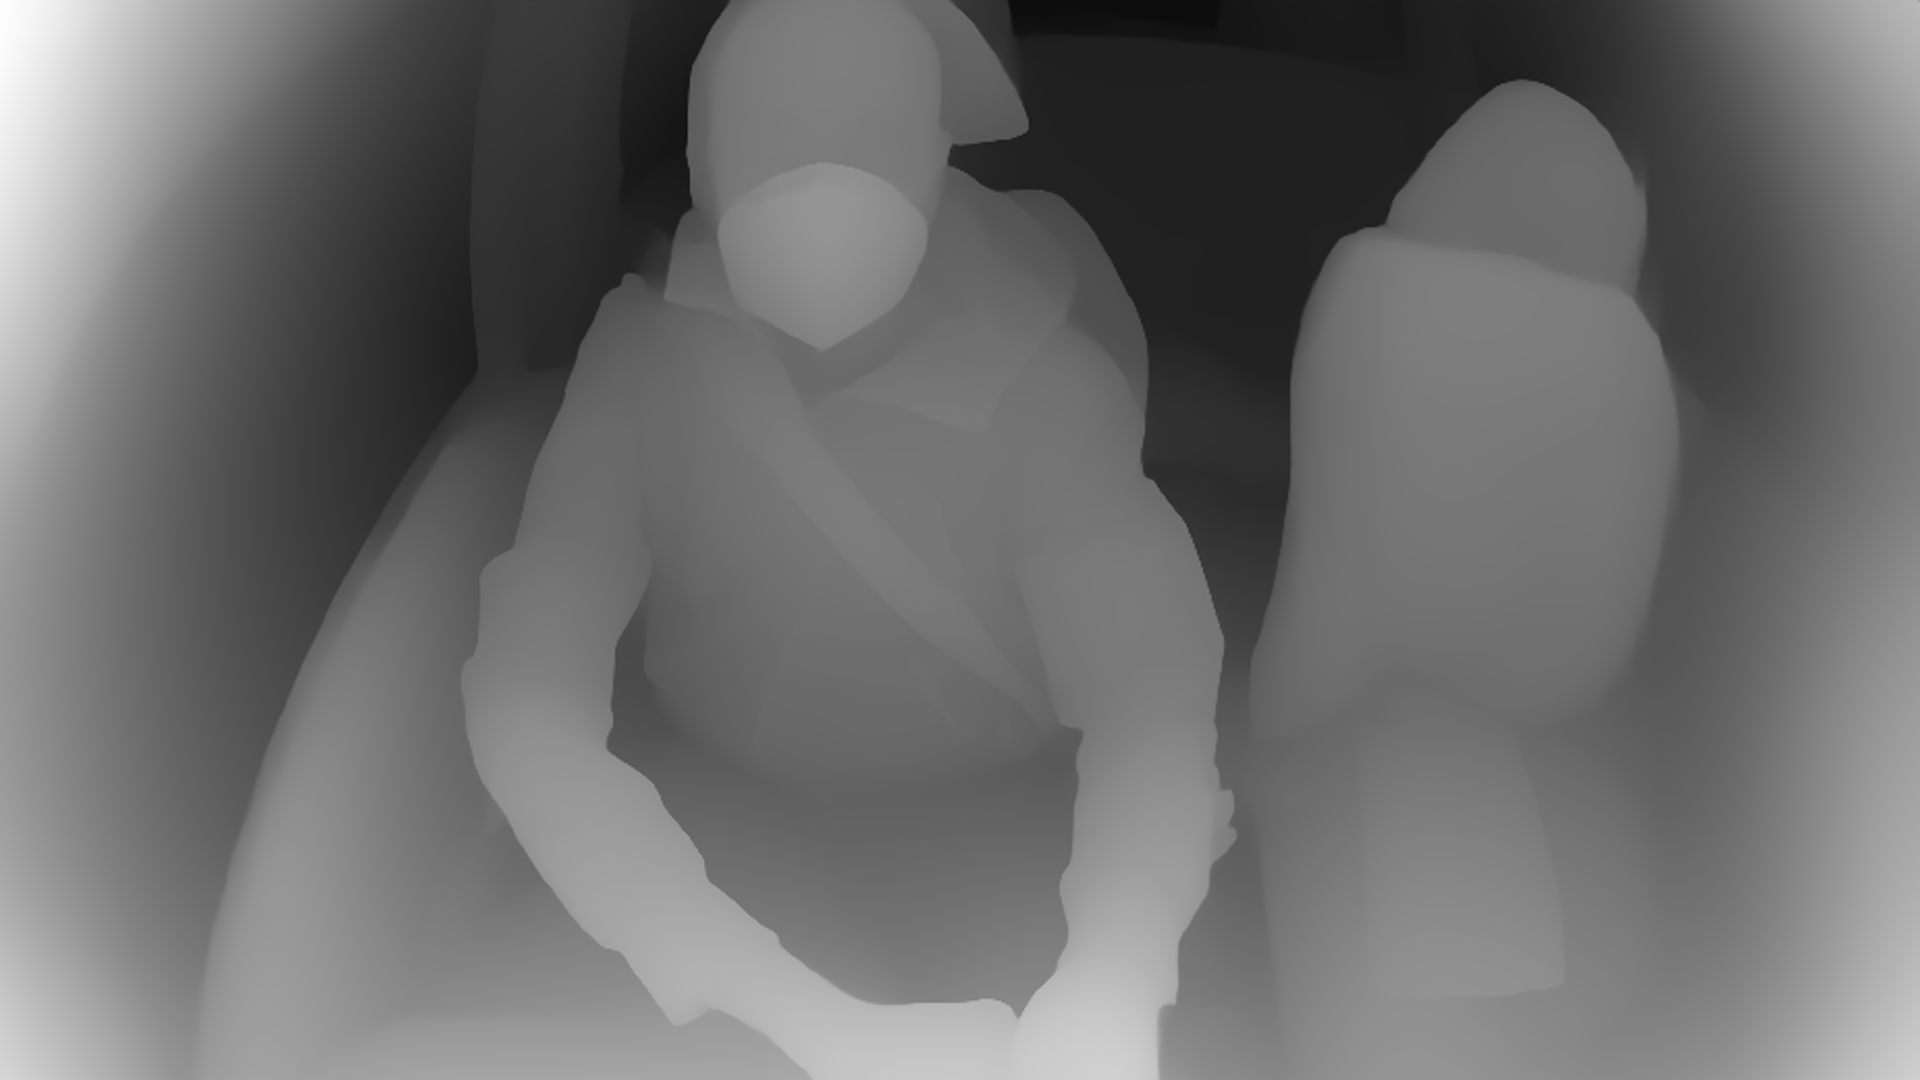

In [26]:
# "depth-anything/Depth-Anything-V2-Base-hf"  # way slower
image = Image.open(sample_img_path)
depth = pipe(image)["depth"]
depth